<a href="https://colab.research.google.com/github/benwtks/machine-learning/blob/master/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as stats

import seaborn as sns
#sns.set()
sns.set(color_codes=True)

There's obviously a lot of statistics in machine learning, so this lab will look at using distributions in numpy and then how it applies to regression

# Gaussian distribution and Probability Density Funcs (PDFs)

The Normal distribution (aka Gaussian distribution) is a continuous probability distribution for a real-valued random variable. 


$$p(x; \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right).$$


*   $f(x)$ is our probability distribution for a random variable $x \in \mathbb{R}$
*   $\sigma$ is our standard deviation
*   $\mu$ is our mean or expectation of the distribution

Let's look at plotting this distribution with $\mu=2$ and $\sigma=4$ in numpy. This will be a PDF, or Probability density function.



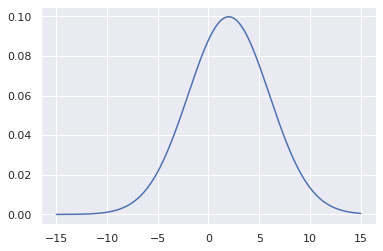

In [6]:
def gaussian(x, mean, stdev):
    return np.exp(-((x-mean)**2)/(2*stdev**2))/(np.sqrt(2*np.pi)*stdev)

x = np.linspace(-15, 15, 250)
plt.plot(x, gaussian(x, 2, 4))

Now we know how to plot a gaussian function, let's look at comparing two functions with different standard deviation, $\sigma$ and mean, $\mu$. These are probability density functions, where the y-axis is probability density and the x-axis is our random variables $X$. With this, we can say that the area will give us the probaility for a given range.

Text(0.5, 1.0, 'Area under the curve gives probability -- here 90% probability limits')

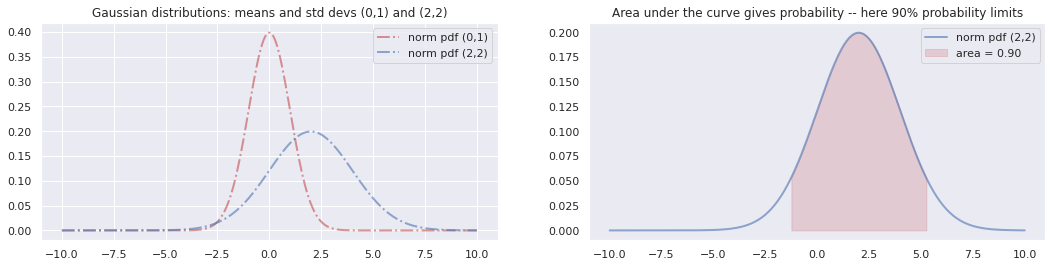

In [7]:
# create grid of 150 points from -3, 5
x = np.linspace(-10, 10, 250)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
ax[0].plot(x, stats.norm.pdf(x), 'r-.', lw=2, alpha=0.6, label='norm pdf (0,1)')
ax[0].plot(x, stats.norm.pdf(x, 2, 2), 'b-.', lw=2, alpha=0.6, label='norm pdf (2,2)')
ax[0].legend()
ax[0].set_title("Gaussian distributions: means and std devs (0,1) and (2,2)")
x_90_idx = (x > stats.norm.ppf(0.05, 2, 2)) & (x < stats.norm.ppf(0.95, 2, 2))
ax[1].grid(False)
ax[1].plot(x, stats.norm.pdf(x, 2, 2), 'b-', lw=2, alpha=0.6,  label='norm pdf (2,2)')
ax[1].fill_between(x[x_90_idx], stats.norm.pdf(x[x_90_idx], 2, 2), color='r', alpha=.2, label='area = 0.90')
ax[1].legend()
ax[1].set_title("Area under the curve gives probability -- here 90% probability limits")

# Cumulative distribution functions (CDFs)

When dealing with continuous distributions (such as the normal distribution), we can use PDFs. If we want the probability from a PDF, we need to find the area (the integral) of this, which we call the CDF (cumulative distribution function). So the CDF is defined as,

$$\mbox{cdf}(x) = \int_{-\infty}^x \mbox{pdf}(x') dx'.$$

Let's look at plotting a CDF and PDF in numpy

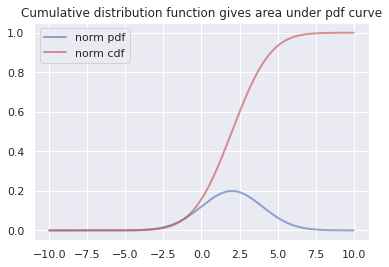

In [8]:
plt.plot(x, stats.norm.pdf(x, 2, 2), 'b-', lw=2, alpha=0.6, label='norm pdf')
plt.plot(x, stats.norm.cdf(x, 2, 2), 'r-', lw=2, alpha=0.6, label='norm cdf')
plt.title("Cumulative distribution function gives area under pdf curve")
plt.legend()

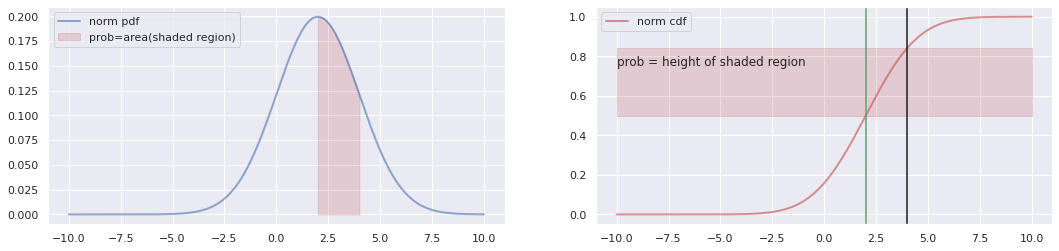

In [9]:
fix, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
x1 = np.linspace(2, 4, 50) # want to graphically 
ax[0].plot(x, stats.norm.pdf(x, 2, 2), 'b-', lw=2, alpha=0.6, label='norm pdf')
ax[0].fill_between(x1, stats.norm.pdf(x1, 2, 2), color='r', alpha=.2, label='prob=area(shaded region)')
ax[0].legend()


ax[1].plot(x, stats.norm.cdf(x, 2, 2), 'r-', lw=2, alpha=0.6, label='norm cdf')
ax[1].axvline(2, color = 'g')
ax[1].axvline(4, color = 'k')
y_2 = stats.norm.cdf(2,2,2)
y_4 = stats.norm.cdf(4,2,2)
ax[1].text(-10,.75,"prob = height of shaded region")

ax[1].fill_between(x, y_2, y_4, color='r', alpha=0.2)
ax[1].legend()

# Linear regression

Working on linear regression, it's helpful to look at the statistics. Explicitly modelling our errors will have some benefits. For example in allowing us to express the level of uncertainty in our estimate of the model parameters $w$ - if we change $w$ a bit, do we still have a _good_ model?

## Linear regression using variance and covariance

In [10]:
# Let us return to the women's 100m sprint times and fit a straight line through the data
olympics100f=np.asarray([
0, 11.90,
1, 11.50,
2, 11.50,
3, 11.00,
4, 11.40,
5, 11.08,
6, 11.07,
7, 11.08,
8, 11.06,
9, 10.97,
10, 10.54,
11, 10.82,
12, 10.94,
13, 10.75,
14, 10.93,
15, 10.78,
16, 10.75,
17, 10.71])

odate_f = olympics100f[::2]
otime_f = olympics100f[1::2]

11.494210526315785 -0.05304437564499428


Text(0.5, 1.0, 'The data that the learnt function produces does not look like the real data')

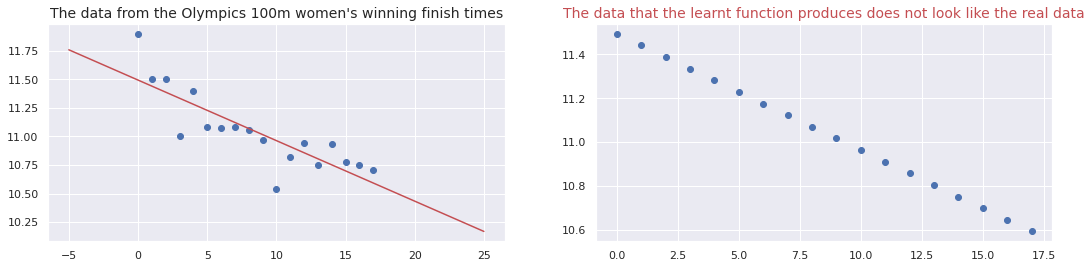

In [11]:
def linear_fit(X,y):
    covariance = (X*y).mean() - (X.mean()*y.mean())
    variance = (X**2).mean() - (X.mean())**2
    w1 = covariance/variance
    w0 = y.mean() - w1*X.mean()
    return w0, w1

w0fit, w1fit = linear_fit(odate_f, otime_f)

# Give f(n;linear_fit(Xdata,ydata)) - i.e. give y of graph from linear fit params
def learnt_fn(Xvariable, Xdata, ydata):
    X = Xvariable
    w_hat = linear_fit(Xdata, ydata)
    fn = 0.
    for i in range(len(w_hat)):
        fn += w_hat[i]*X**i
    return fn

print(w0fit, w1fit)

x = np.linspace(-5, 25, 250)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
ax[0].scatter(odate_f, otime_f)
ax[0].plot(x, learnt_fn(x, odate_f, otime_f), c='r')
ax[0].set_title("The data from the Olympics 100m women's winning finish times", fontsize=14)

# Calculate same graph but within the bounds of actual data and as scatter
ax[1].scatter(odate_f, learnt_fn(odate_f, odate_f, otime_f) )
ax[1].set_title("The data that the learnt function produces does not look like the real data", fontsize=14, color='r')

## Thinking generatively

The processes that generates our real data for a linear regression problem will, in general, be very complex. With the sprinter example from FCML, we couldn’t even begin to make a near-perfect model of one sprinter and the events surrounding his preparation and performance, let alone several of them and all of the other factors.

That said, it's useful to think about our model "generating" some data to match the actual data.

Considering a piece of data and a linear regression model, we can imagine the errors and see that

1. They are different at each year. Some are positive, some negative and they all have different magnitudes.
2. There does not seem to be any obvious relationship between the size (or
direction) of the error and the year. The error does not appear to be a function
of $x$, the Olympic year.






We can use tools from statistics to generate a random amount of time (in seconds) that could be either positive or negative and was, on average, roughly the same size as the errors. We could then add this to $w^Tx$.

$$t_n = w^Tx_n + \epsilon_n$$

Now, decide on a distribution for $\epsilon_n$. Of course this error, the difference between the generated data and actual data, will be a continuous quantity, so our $\epsilon_n$ should be a continuous random variable.

It seems reasonable to assume these are independent. We will look at the joint probability of all errors. The joint probability of the real data given the generated linear regression model.

Our model consists of two components

1.   a **deterministic component** ($w^Tx$), sometimes referred to as the _trend_
2.   a **random component** ($\epsilon_n$), sometimes referred to as _noise_.

It's worth noting that we are not restricted to additive noise, for some applications a multiplicative term might be better ($t_n=f(x;w)\epsilon_n$). For example, the degradation of image pixels is often modelled with multiplicative noise.



### Likelihood



Taking this, we will use a gaussian distribution for our $\epsilon_n$. We want to predict the target on average, so the residuals $r_n:=t_n - w_0 - w_1 x_n, n=1, \ldots, N$ should be distributed around 0, this will be our mean, $\mu$. $$t_n = f(x_n; w_0, w_1) + \epsilon_n = w^Tx_n + \epsilon_n, \epsilon_n \sim \mathcal{N}(0,\sigma^2)$$

The effect of adding a random variable to the model is that the output of the model, t, is now itself a random variable. In other words, there is no single value of $t_n$ for a particular $x_n$. As such, we cannot use the loss as a means of optimising $w$ and $\sigma^2$

Adding a constant ($w^Tx_n$) to a Gaussian random variable is equivalent to another Gaussian random variable with the mean shifted by the same constant. Therefore, the random variable tn has the density function,
$$p(t_n \quad|\quad f(x_n; w_0, w_1)) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left[-\frac{1}{2\sigma^2} (t_n - (w_0 + w_1 x_n))^2 \right]$$ This is the likelihood function $L$ of the model for the datum $(x_n, t_n)$.

The joint probability of two random variables $C$ and $D$ stores the probability of jointly observing values $C=c$ and $D=d$ and is denoted $P(C=c, D=d)$. If the two variables $C$ and $D$ are independent $P(C=c, D=d) = P(C=c) P(D=d)$

The joint probability of observing the data-set $D=\{(x_1, t_1), (x_2, t_2), \ldots, (x_N, t_N)\}$ is the product of the probabilities of each individual datum: $p(t_1\;|\;  w_0 + w_1 x_1)p(t_2 \;|\;  w_0 + w_1 x_2)\cdots p(t_N \;|\;  w_0 + w_1 x_N)=:\prod_{n=1}^N p(t_n \;|\;  w_0 + w_1 x_n)$.

We will evaluate this joint probability over all of the responses in our dataset, to give good $w_0$ and $w_1$ for our data.

**Maximum likelihood estimation:**

$$\mathcal{L}(w_0, w_1, \sigma) = -L = -\ln \prod_{n=1}^N p(t_n \;|\;  w_0 + w_1 x_n) \\= -\sum_{n=1}^N \ln p(t_n \;|\;  w_0 + w_1 x_n)
= \frac{N}{2}\ln(2\pi\sigma^2) + \frac{1}{2\sigma^2}\sum_{n=1}^N r_n^2.$$

The minimisation of $L(w_0,w_1,\sigma)$  with respect to $w=(w_0,w_1)$  is exactly the same as in ordinary linear regression. The additional parameter  σ  can also be estimated by setting the corresponding derivative of  $L$  with respect to  $\sigma$  to  $0$ . The parameter  $\sigma$  is an additional handle to characterise the model that is learnt. It will give a quantification of the uncertainty of the model, and the uncertainty of the model predictions as well

#### Full derivation (not important, just a good exercise)

Now let's look at deriving the loss function.

For convenience, we take the logarithm of the likelihood for the data set $D$ and maximise that instead. Alternatively we can minimise the negative of the log-likelihood (using the fact that the log of a product is a the sum of the logs). First we will use $\ln(ab)=\ln(a)+\ln(b)$.

$$\mathcal{L}(w_0, w_1, \sigma) = -L = -\ln \prod_{n=1}^N p(t_n \;|\;  w_0 + w_1 x_n) = -\sum_{n=1}^N \ln p(t_n \;|\;  w_0 + w_1 x_n)$$

$$= -\sum_{n=1}^N \ln \frac{1}{\sqrt{2\pi}\sigma} \exp\left[-\frac{1}{2\sigma^2} (t_n - (w_0 + w_1 x_n))^2 \right]
= -\sum_{n=1}^N \left[\ln \frac{1}{\sqrt{2\pi}\sigma} + \ln \exp\left(-\frac{1}{2\sigma^2} (t_n - (w_0 + w_1 x_n))^2\right)\right]$$

Using the fact that $\ln(\frac{1}{a})=-\ln(a^{-1})=-\ln(a)$ and $\ln(e^{x})=x$, we continue

$$= -\sum_{n=1}^N \left[-\ln \left(\sqrt{2\pi}\sigma\right) - \left(\frac{1}{2\sigma^2} (t_n - (w_0 + w_1 x_n))^2\right)\right]
\\= \sum_{n=1}^N \left[\ln \left(\sqrt{2\pi}\sigma\right) + \left(\frac{1}{2\sigma^2} (t_n - (w_0 + w_1 x_n))^2\right)\right]
$$

Now looking at this $\ln\left(\sqrt{2\pi}\sigma\right)$ we can remove the sqrt, $\ln\left(\sqrt{2\pi}\sigma\right)= \ln \left(\sqrt{{\left(\sqrt{2\pi}\sigma\right)}^{2}}\right) = \frac{1}{2} \ln \left({\left(\sqrt{2\pi}\sigma\right)^{2}}\right) = \frac{1}{2} \ln \left(2\pi\sigma^{2}\right)$

$$= \sum_{n=1}^N \left[\frac{1}{2} \ln \left(2\pi\sigma^{2}\right)\right] + \sum_{n=1}^N \left[\frac{1}{2\sigma^2} (t_n - (w_0 + w_1 x_n))^2\right]
\\= \frac{N}{2} \ln \left(2\pi\sigma^{2}\right) + \sum_{n=1}^N \left[\frac{1}{2\sigma^2} (t_n - (w_0 + w_1 x_n))^2\right]$$

Remember we defined our residuals as $r_n:=t_n - w_0 - w_1 x_n, n=1, \ldots, N$ so now we have

$$\\= \frac{N}{2} \ln \left(2\pi\sigma^{2}\right) + \sum_{n=1}^N \frac{r_{n}^2}{2\sigma^2}
\\= \frac{N}{2} \ln \left(2\pi\sigma^{2}\right) + \frac{1}{2\sigma^2} \sum_{n=1}^N r_{n}^2$$

$$\therefore  \mathcal{L}(w_0, w_1, \sigma) = \frac{N}{2}\ln(2\pi\sigma^2) + \frac{1}{2\sigma^2}\sum_{n=1}^N r_n^2.$$

#### Negative log likelihood for normal distribution: *negloglik_normal*

In [12]:
def negloglik_normal(X, y, w0, w, sigma):
    loglik = 0 # NOTE: this has been corrected
    for x1, y1 in zip(X, y):
        prediction1 = w0 + np.dot(w, x1)
        residual = y1 - prediction1
        loglik += np.log(stats.norm.pdf(residual, 0, sigma)) # computes log(probability of residual) assuming gaussian
    return -loglik

In [13]:
# Showing the negloglik_normal for various values
w0best, w1best = linear_fit(odate_f, otime_f) # linear regression fit
w_trial = np.array([[12.0, -.1], [11.5, -.03], [12.5, -.03], [11.0,-.07],  [w0best, w1best]])
for w0, w1 in w_trial:
    nll = negloglik_normal(odate_f, otime_f, w0, w1, .05)
    print((w0,w1), nll)

(12.0, -0.1) 338.2577126737121
(11.5, -0.03) 281.5177126737122
(12.5, -0.03) 5333.517712673712
(11.0, -0.07) 1578.3977126737134
(11.494210526315785, -0.05304437564499428) 83.64962185843893


### Generative model: Making the model produce outputs that "looks like" real data

Now we will analyse the results of the model fit. Let's verify the loss-function minimising weights give rise to residuals that satisfy the conditions $$\sum_n r_n \approx 0, \quad \mbox{and} \quad \sum_n x_n r_n \approx 0.$$

In [14]:
residuals_f = learnt_fn(odate_f, odate_f, otime_f)-otime_f


print("Sum of the residuals = ", residuals_f.sum())
print("Sum of product(residual times input): r_n times x_n  = ", odate_f.dot(residuals_f))

Sum of the residuals =  -3.552713678800501e-15
Sum of product(residual times input): r_n times x_n  =  2.4158453015843406e-13


As you can see these are very small values with very low orders of magnitude. Now let's look at the distribution of these residuals

Text(0.5, 1.0, "Histogram of the residuals (women's)")

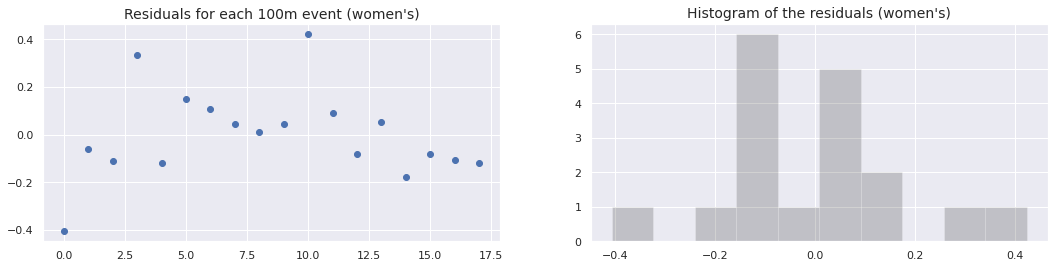

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
ax[0].scatter(odate_f, residuals_f)
ax[0].set_title("Residuals for each 100m event (women's)", fontsize = 14)
ax[1].hist(residuals_f, color='k',alpha=0.2)
ax[1].set_title("Histogram of the residuals (women's)", fontsize = 14)

### Capturing the characteristics of the residuals

The best fit line was a model that minimised the loss function, but the model "produces" data that does not look like real data. If we manage to also model the residuals, by fitting their histogram to a probability distribution we would then have an appropriate generative model. We do this using eq. (2.35) of FCML for the best-fit variance  $\sigma^2$:

$$\widehat{\sigma^2} = \frac{1}{N} \sum_{n=1}^N (t_n - \widehat{\mathbf{w}}^T\mathbf{x}_n)^2.$$

#### Max likelihood derivatives from FCML

As with the least squares solution derived in chapter 1 of FCML, We can find the optimal parameters by taking derivatives. We want to find the turning point, so we set the derivative to 0 to see when the rate of change reaches 0. 

Since we only care about our vector $\textbf{w}$ we will take the partial derivative: $\frac{\partial \mathcal{L}}{\partial \textbf{w}}$ - the partial derivative of our loss function, the negative natural log of our conditional probability, with respect to $\textbf{w}$.

We will use the facts that $w_0+w_1x_n=\textbf{w}^Tx_n$ and $\textbf{w}^Tx_n = x^T_n\textbf{w}$

$$\frac{\partial \mathcal{L}}{\partial \textbf{w}} = \frac{\partial}{\partial \textbf{w}} \left( \frac{N}{2} \ln \left(2\pi\sigma^{2}\right) + \sum_{n=1}^N \left[\frac{1}{2\sigma^2} (t_n - (w_0 + w_1 x_n))^2\right]\right) \\= \frac{\partial}{\partial \textbf{w}} \left( \sum_{n=1}^N \left[\frac{1}{2\sigma^2} (t_n - (w_0 + w_1 x_n))^2\right]\right) \\= \sum_{n=1}^N \left( \frac{1}{2\sigma^2} \frac{\partial}{\partial \textbf{w}}(t_n - \textbf{w}^Tx_n)^2\right) \\= \sum_{n=1}^N \frac{1}{\sigma^2} (t_n - \textbf{w}^Tx_n) \frac{\partial}{\partial \textbf{w}}\left(t_n - \textbf{w}^Tx_n\right) \\= \sum_{n=1}^N \frac{1}{\sigma^2} x_n (t_n - \textbf{w}^Tx_n) \\= \sum_{n=1}^N \frac{1}{\sigma^2} x_n (t_n - x^T_n\textbf{w}) \\= \frac{1}{\sigma^2}  \sum_{n=1}^N x_nt_n - x_nx^T_n\textbf{w}$$

Now we have $\frac{\partial \mathcal{L}}{\partial \textbf{w}}$, we can set it to $\textbf{0}$ to find the turning point of $\mathcal{L}$. Note that $\textbf{w}$ is a vector so we're using $\textbf{0}$, a vector of 0's of the same size.

$$\frac{\partial \mathcal{L}}{\partial \textbf{w}} = \frac{1}{\sigma^2}  \sum_{n=1}^N x_nt_n - x_nx^T_n\textbf{w} = \textbf{0}$$

Remember our definitions of $\textbf{X}$ and $\textbf{t}$

$$\textbf{X} = \begin{bmatrix}
                    x^T_1 \\
                    x^T_2 \\
                    \text{.} \\
                    \text{.} \\
                    x^T_n
                \end{bmatrix}
            = \begin{pmatrix}
                   1 & x_1 \\
                   1 & x_2 \\
                   \text{.} & \text{.} \\
                   \text{.} & \text{.} \\
                   1 & x_N
              \end{pmatrix},
  \textbf{t} = \begin{bmatrix}
                    t_1 \\
                    t_2 \\
                    \textbf{.} \\
                    \textbf{.} \\
                    t_N
               \end{bmatrix}$$

With this notation we can say that $$\sum_{n=1}^N x_nt_n = \textbf{X}^T\textbf{t}, \quad \mbox{and} \quad \sum_{n=1}^N x_nx^T_n = \textbf{X}^T\textbf{X}\textbf{w}$$

This allows us to rewrite the derivative in matrix form

$$\frac{\partial \mathcal{L}}{\partial \textbf{w}} = \frac{1}{\sigma^2}  \sum_{n=1}^N \textbf{X}^T\textbf{t} - \textbf{X}^T\textbf{X}\textbf{w} = \textbf{0}$$

Rearranging this, we get our equation for the optimal $\textbf{w}$
$$\widehat{\textbf{w}} = \left(\textbf{X}^T\textbf{X}\right)^{-1}\textbf{X}^Tt$$

We can see this is the same as the result from chapter 1 of FCML, verifying that this is equivalent.

Doing the same for $\sigma$, we can get an equation for $\sigma^2$
$$\frac{\partial \mathcal{L}}{\partial \sigma} = -\frac{N}{\sigma}+\frac{1}{\sigma^3}\sum_{n=1}^N(t_n-x^T\widehat{\textbf{w}})^2$$.

Rearranging this, we get the maximum likelihood estimation for $\sigma^2$ assuming $\textbf{w}=\widehat{\textbf{w}}$
$$\widehat{\sigma^2} = \frac{1}{N} \sum_{n=1}^N (t_n - \widehat{w}^Tx_n)$$

#### Python

Text(0.5, 1.0, "Women's 100m: histogram of residuals and gaussian pdf with same std. dev.")

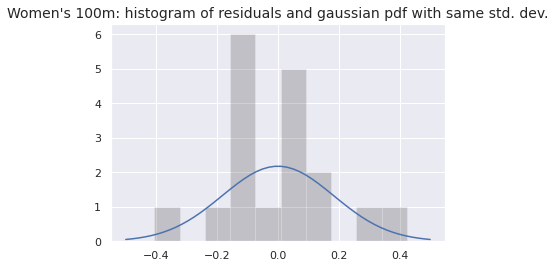

In [17]:
res_sigma_f = np.sqrt(np.square(residuals_f).sum()/len(residuals_f)) # standard deviation of residuals
x = np.linspace(-0.5,0.5,50)
plt.plot(x, stats.norm.pdf(x, 0, res_sigma_f), 'b-')
plt.hist(residuals_f,color='k',alpha=0.2)
plt.title("Women's 100m: histogram of residuals and gaussian pdf with same std. dev.", fontsize = 14)

### Effect of noise on parameter estimates

Now let's look at the linear fits from our generative model following the gaussian distribution, following 2.1 of _FCML_.


As you can see, the gaussian distribution gives us a range of results with different probabilities.

In [ ]:
def data_generator(n):
    noise = np.random.normal(0, 1, n)
    x = np.linspace(0, 1, n)
    y = -2 + 3*x + noise
    return x, y

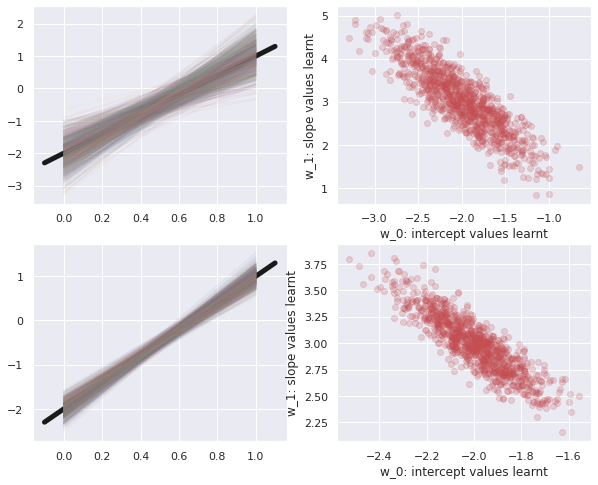

In [39]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

# define a slightly bigger domain for the plotting of the TRUE underlying deterministic function 
X0 = np.linspace(-0.1,1.1,100)
X = np.linspace(0,1,100)

ax[0][0].plot(X0, -2+3*X0, lw = 5, c='k') # lw sets line weight, here a heavy line
ax[1][0].plot(X0, -2+3*X0, lw = 5, c='k')

def plot_fits_for_distribution(no_operations, sample_size, X, ax0):
  l_wts = []
  l_residuals = []
  l_sig = []
  for i in range(no_operations):  # no_operations (e.g. 1000) data fitting operations
      # generate a training sample of SIZE sample_size (e.g. 20)
      Xd, yd = data_generator(sample_size)
      # Calculate linear_fit using variance and covariance, then residuals
      best_fit_w = linear_fit(Xd, yd)
      residuals_w = learnt_fn(Xd, Xd, yd)-yd
      # Calculate best_fit sigma using equation from FCML
      best_fit_sigma = np.sqrt(np.square(residuals_w).sum()/len(residuals_w))

      # Append linear_fit weights and sigmas
      l_wts.append(np.asarray(best_fit_w))
      l_residuals.append(residuals_w)
      l_sig.append(best_fit_sigma)
      # Plot the learnt function for generated data with some transparency
      ax0.plot(X, learnt_fn(X, Xd, yd), alpha=0.05)
    
  l_wts = np.asarray(l_wts)
  l_residuals = np.asarray(l_residuals)
  l_sig = np.asarray(l_sig)
  return {'weights':l_wts,'residuals':l_residuals,'sigmas':l_sig}

l1 = plot_fits_for_distribution(1000,  20,   X, ax[0][0])
l2 = plot_fits_for_distribution(1000, 180,   X, ax[1][0])

# Let's plot the w_0 and w_1 together,
# the correlation is intuitive, for y=w0+w1x , high slopes will have low intercepts
# The correlation doesn't matter though, let's just look at the spread of values
def plot_weights(ax, l_vals):  
  ax.scatter(l_vals[:,0], l_vals[:,1], alpha=0.2, c='r')
  ax.set_xlabel('w_0: intercept values learnt')
  ax.set_ylabel('w_1: slope values learnt')

plot_weights(ax[0][1], l1['weights'])
plot_weights(ax[1][1], l2['weights'])

## Bayesian Inference

### Statistical inference

Statistical inference is the process of using data analysis to deduce properties of an underlying distribution probability. Inferential statistical analysis infers properties of a population, for example by testing hypotheses and deriving estimates.

### Prior, Posterior, Likelihood

#### Prior probability
In Bayesian statistical inference, a prior probability distribution, often simply called the prior, of an uncertain quantity is the probability distribution that would express one's beliefs about this quantity before some evidence is taken itno account. For example, the prior could be the probability distribution rperesenting the relative proportions of voters who will vote for a particula politician in a future election. The unknown quantity may be a parameter of the moel or a latent variable rather than an observable variable.

#### Posterior probability
Meanwhile, the posterior probability of a random event or an uncertain proposition is the conditional probability that is assigned after the relevant evidence or background is taken into account. "Posterior", in this context, means after taking into account the relevant evidence related to the particular case being examined.

The posterior probability is the probability of the parameters $\theta$ given the evidence $X$: $p(\theta|X)$.

#### Likelihood function
As covered earlier, the likelihood function measures the goodness of fit of a statistical model to a sample of data.

It contrasts with the posterior probability, as the probability of the evidence given the parameters: $p(X|\theta)$

#### Relation between posterior and likelihood

With Bayes' theorem, $p(A|B)=\frac{p(B|A)p(A)}{p(B)}$, we can say that, given a prior belief that a probability distribution function is $p(\theta)$ and that the observations $x$ have a likelihood $p(x|\theta)$, then the posterior probability is defined as

$$\text{Posterior} = p(\theta|x) = \frac{p(x|\theta)}{p(x)}p(\theta)$$

Where $p(x)$ is the normalising constant and is calculated as

$$p(x) = \int p(x|\theta)p(\theta)d\theta \\\text{ (for continuous } \theta \text{, sum for discrete)}$$

In other words, we can say that

$p(\theta|x) = \frac{p(x|\theta)}{p(x)}p(\theta) = \frac{1}{p(x)} p(x|\theta) p(\theta) = \frac{1}{p(x)} \times Likelihood \times Prior$

$\therefore Posterior \propto Likelihood \times Prior$

### What proportion of the earth's surface is water?

_(From "Rethinking Statistics" by Richard McElreath)_

You throw a small, but accurately drawn, globe in the air and catch it. Every time your right index finger falls on a blue patch indicating water, you record "W", else, record "L". From a finite sample of globe tosses you wish to infer the proportion of the earth's surface covered with water.

Let the unknown proprtion of water be denoted $\theta$ . The task is to go from the evidence of a finite sample of the form "WLWWWLWLL...." with the event of "W" occurring considered a "success" with probability $\theta$ and "L" a failure occurring with probability $1-\theta$ .

Below in the posterior_grid_approx function we use Bayes' rule to infer, from the observation of a sequence (of length "tosses" or $N$ ) containing a number ("success" or  $n_W$) of occurrences of "W", the likely fraction of planetary water coverage as represented by the globe. For each hypothetical value of this fraction $\theta$ , stored in the p_grid array, the corresponding probability of seeing the observed data using the binomial probability mass function stats.binom.pmf: $$\genfrac(){0pt}{0}{N}{n_W}\theta^{n_W}(1-\theta)^{N-n_W}$$

In [ ]:
def posterior_grid_approx(grid_points, success, tosses):
 
    # define grid: introduce points theta
    # posterior probability, p(theta) is returned
    p_grid = np.linspace(0, 1, grid_points)

    # define prior (uniform)
    # grid_points is an integer for number of points
    # repeat will give us a vector of 1/grid_point's of size grid_points
    prior = np.repeat(1/grid_points, grid_points)
  
    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior